In [11]:
#!pip install segmentation-models

In [12]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

In [13]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## part1: create annot_stack of the data (skip if already done)

In [4]:
# folder_path = '../../53_bact_gut_annot/exp3'
# file_list = os.listdir(folder_path)
# file_list = [f for f in file_list if 'set1' in f.lower()]
# len(file_list)

20

In [5]:
# num_channels = 6
# super_stack = np.empty((len(file_list), num_channels, 2048, 2048), dtype=np.uint16)

In [6]:
# for i, file_name in enumerate(file_list):
#     file_path = os.path.join(folder_path, file_name)
#     image = tifffile.imread(file_path)
#     super_stack[i] = image

# super_file_name = 'exp3_stack_output.tiff'
# output_file = os.path.join(folder_path, super_file_name)
# tifffile.imsave(output_file, super_stack)

In [7]:
# del super_stack

## part2: load superstack (skip to part3 if already have single stacks)

In [14]:
# folder_path = '../../53_bact_gut_annot/exp3'
# super_file_name = 'exp3_stack_output.tiff'
# img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

In [15]:
# img_stack.shape

(20, 6, 2048, 2048)

In [16]:
# channel_names = {'0': 'bf max',
# '1' : 'bf min',
# '2' : 'green chan',
# '3' : 'red chan',
# '4' : 'bact mask',
# '5' : 'gut mask',}
# channel_names

{'0': 'bf max',
 '1': 'bf min',
 '2': 'green chan',
 '3': 'red chan',
 '4': 'bact mask',
 '5': 'gut mask'}

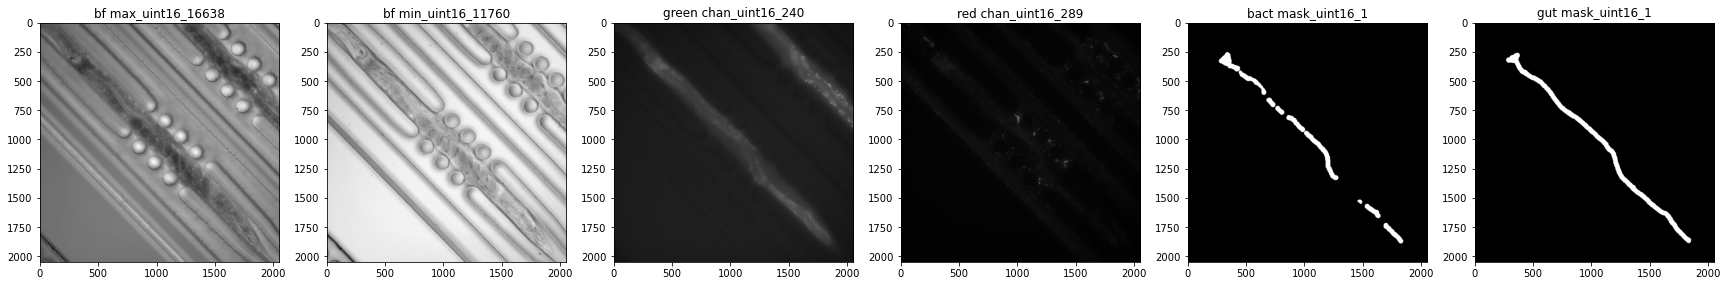

In [17]:
# num_imgs = img_stack[0].shape[0]
# fig, axs = plt.subplots(1,num_imgs, figsize=(num_imgs*5,5))
# for i in range(num_imgs):
#     img = img_stack[0][i]
#     axs[i].imshow(img, cmap='gray')
#     data_type = img.dtype
#     val_range = np.ptp(img)
#     title = '{}_{}_{}'.format(channel_names[str(i)],data_type,val_range)
#     axs[i].title.set_text(title)
# plt.show()

In [18]:
# bf_stack = np.squeeze(img_stack[:, 0, :, :])
# greenc_stack = np.squeeze(img_stack[:, 2, :, :])
# redc_stack = np.squeeze(img_stack[:, 3, :, :])
# bactmask_stack = np.squeeze(img_stack[:, 4, :, :])
# gutmask_stack = np.squeeze(img_stack[:, 5, :, :])
# del img_stack


# output_file = os.path.join(folder_path, 'bf_only.tiff')
# tifffile.imsave(output_file, bf_stack)
# output_file = os.path.join(folder_path, 'greenc_only.tiff')
# tifffile.imsave(output_file, greenc_stack)
# output_file = os.path.join(folder_path, 'redc_only.tiff')
# tifffile.imsave(output_file, redc_stack)
# output_file = os.path.join(folder_path, 'bactmask_only.tiff')
# tifffile.imsave(output_file, bactmask_stack)
# output_file = os.path.join(folder_path, 'gutmask_only.tiff')
# tifffile.imsave(output_file, gutmask_stack)

## Part3: Open bf stack and gutmask_stack only

In [19]:
folder_path = '../../53_bact_gut_annot/exp3'
bf_stack = tifffile.imread(os.path.join(folder_path, 'bf_only.tiff'))
greenc_stack = tifffile.imread(os.path.join(folder_path, 'greenc_only.tiff'))
gutmask_stack = tifffile.imread(os.path.join(folder_path, 'gutmask_only.tiff'))

In [20]:
bf_stack.shape

(20, 2048, 2048)

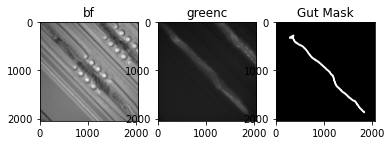

In [21]:
plt.subplot(1,3,1)
plt.imshow(bf_stack[0], cmap='gray')
plt.title('bf')
plt.subplot(1,3,2)
plt.imshow(greenc_stack[0], cmap='gray') 
plt.title('greenc')
plt.subplot(1,3,3)
plt.imshow(gutmask_stack[0], cmap='gray')
plt.title('Gut Mask')
plt.show()

In [22]:
def center_norm_im_float32(images):
    images_float = images.astype(np.float32)
    mean = np.mean(images_float)
    std = np.std(images_float)
    normalized_stack = (images_float-mean)/std
    return normalized_stack

def im_float32(images):
    images_float = images.astype(np.float32)
    return images_float

In [23]:
bf_imgs_norm = center_norm_im_float32(bf_stack)
greenc_imgs_norm = center_norm_im_float32(greenc_stack)
mask_imgs = im_float32(gutmask_stack)

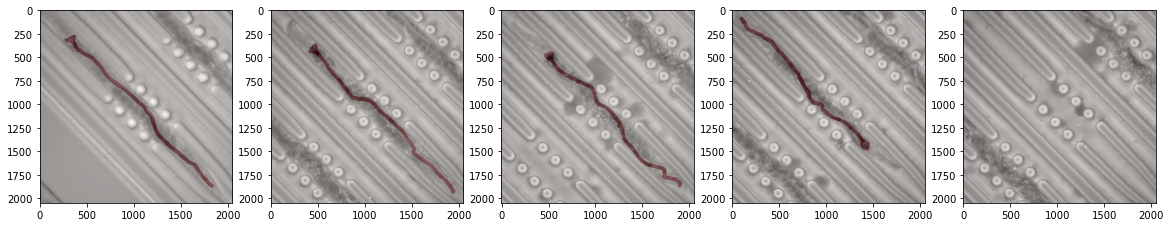

In [24]:
# Plotting a few images and masks to make sure they align
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    axs[i].imshow(bf_imgs_norm[i], cmap='gray')
    axs[i].imshow(mask_imgs[i], cmap='Reds', alpha=0.3)

plt.show()

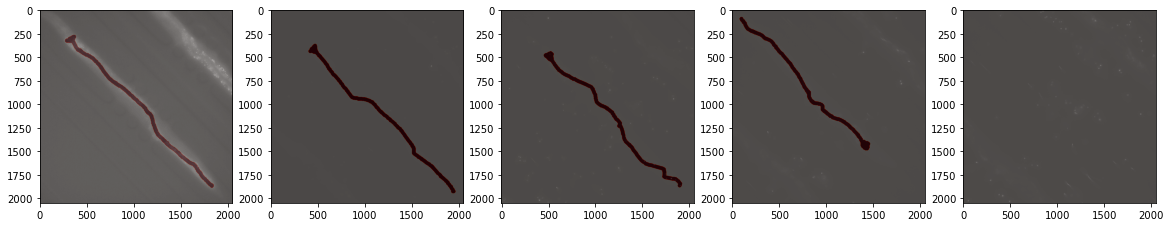

In [25]:
# Plotting a few images and masks to make sure they align
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    axs[i].imshow(greenc_imgs_norm[i], cmap='gray')
    axs[i].imshow(mask_imgs[i], cmap='Reds', alpha=0.3)

plt.show()

In [26]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# axes[0, 0].hist(edf_stack.flatten(), bins=20, color='blue', alpha=0.5)
# axes[0, 0].set_title('Original edf Image Histogram')
# axes[0, 0].set_xlabel('Pixel Intensity')
# axes[0, 0].set_ylabel('Frequency')

# axes[0, 1].hist(edf_imgs_norm.flatten(), bins=20, color='green', alpha=0.5)
# axes[0, 1].set_title('Normalized edf Image Histogram')
# axes[0, 1].set_xlabel('Pixel Intensity')
# axes[0, 1].set_ylabel('Frequency')

# axes[0, 0].hist(greenc_stack.flatten(), bins=20, color='blue', alpha=0.5)
# axes[0, 0].set_title('Original edf Image Histogram')
# axes[0, 0].set_xlabel('Pixel Intensity')
# axes[0, 0].set_ylabel('Frequency')

# axes[0, 1].hist(greenc_imgs_norm.flatten(), bins=20, color='green', alpha=0.5)
# axes[0, 1].set_title('Normalized edf Image Histogram')
# axes[0, 1].set_xlabel('Pixel Intensity')
# axes[0, 1].set_ylabel('Frequency')

# axes[1, 0].hist(gutmask_stack.flatten(), bins=20, color='red', alpha=0.5)
# axes[1, 0].set_title('Original Mask Histogram')
# axes[1, 0].set_xlabel('Pixel Intensity')
# axes[1, 0].set_ylabel('Frequency')

# axes[1, 1].hist(mask_imgs.flatten(), bins=20, color='orange', alpha=0.5)
# axes[1, 1].set_title('Normalized Mask Histogram')
# axes[1, 1].set_xlabel('Pixel Intensity')
# axes[1, 1].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

In [27]:
# import matplotlib.patches as patches

# def plot_image_with_patches(image, px, py, sx, sy):
#     fig, ax = plt.subplots()
#     ax.imshow(image, cmap='gray')

#     r, c = image.shape
#     for x in range(0, r, sx):
#         for y in range(0, c, sy):
#             rect = patches.Rectangle((y, x), px, py, linewidth=1, edgecolor='r', facecolor='none')
#             ax.add_patch(rect)

#     #plt.show()

# plot_image_with_patches(edf_imgs_norm[3],128,128,64,64)

In [28]:
# plot_image_with_patches(edf_imgs_norm[3], 256, 256, 128, 128)

In [29]:
bf_imgs_norm.shape

(20, 2048, 2048)

In [30]:
mask_imgs.shape

(20, 2048, 2048)

In [31]:
greenc_imgs_norm.shape

(20, 2048, 2048)

In [32]:
new_shape = (20, 2048, 2048, 1)
bf_imgs_norm = bf_imgs_norm.reshape(new_shape)
bf_imgs_norm.shape

(20, 2048, 2048, 1)

In [33]:
new_shape = (20, 2048, 2048, 1)
greenc_imgs_norm = greenc_imgs_norm.reshape(new_shape)
greenc_imgs_norm.shape

(20, 2048, 2048, 1)

In [34]:
new_shape = (20, 2048, 2048, 1)
mask_imgs = mask_imgs.reshape(new_shape)
mask_imgs.shape

(20, 2048, 2048, 1)

## Extracting patches

In [35]:
im_patches_g = tf.image.extract_patches(images=greenc_imgs_norm,
                           sizes=[1, 256, 256, 1],
                           strides=[1,128, 128, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

im_patches_bf = tf.image.extract_patches(images=bf_imgs_norm,
                           sizes=[1, 256, 256, 1],
                           strides=[1,128, 128, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches = tf.image.extract_patches(images=mask_imgs,
                           sizes=[1, 256, 256, 1],
                           strides=[1,128, 128, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

print('mask patches:',mask_patches.shape)
print('g patches:',im_patches_g.shape)
print('bf patches:',im_patches_bf.shape)
p_shape = im_patches_g.shape

mask patches: (20, 15, 15, 65536)
g patches: (20, 15, 15, 65536)
bf patches: (20, 15, 15, 65536)


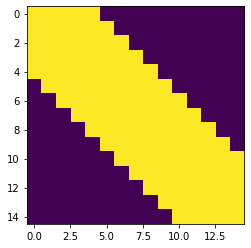

In [36]:
block = np.ones((15,15))
triangle_size = 4
for i in range(block.shape[0]):
    for j in range(block.shape[1]):
        # Replace the pixels of the upper right triangle with the ones from the lower left triangle
        if j > i+triangle_size or i > j+triangle_size:
            block[i,j] = 0     #block[block.shape[0]-1-i,block.shape[1]-1-j]

block_exp = np.expand_dims(np.expand_dims(block,-1),0)
block_exp.shape
plt.imshow(block)

In [37]:
neg_im_patches_g = (im_patches_g+1)*block_exp-1 # unwanted patches will be all -1s
neg_im_patches_bf = (im_patches_bf+1)*block_exp-1 # unwanted patches will be all -1s
neg_mask_patches = (mask_patches+1)*block_exp-1 # unwanted masks will be all -1

neg_im_patches_bf.shape

TensorShape([20, 15, 15, 65536])

In [38]:
neg_mask_patches.shape

TensorShape([20, 15, 15, 65536])

(1, 2048, 2048, 1)
unwanted patches have -1 value


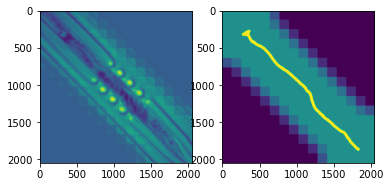

In [39]:
def reconstruct_from_patches(patches, img_shape, patch_size, stride):
    '''stride must be either equal to patch shape or a exact factor of it'''
    # Prepare an empty array to hold the accumulated patches
    img_reconstructed = np.zeros(img_shape, dtype=np.float32)
    counts = np.zeros(img_shape, dtype=np.float32)

    # Prepare indices for extracting patches
    idx_x = np.arange(0, img_shape[1]-patch_size[1]+1, stride[1])
    idx_y = np.arange(0, img_shape[2]-patch_size[2]+1, stride[2])
    i = 0
    for x in idx_x:
        for y in idx_y:
            patch = patches[0,i // len(idx_y), i % len(idx_y),:].numpy().reshape(patch_size)
            img_reconstructed[0, x:x+patch_size[1], y:y+patch_size[2], :] += patch[0]
            counts[0, x:x+patch_size[1], y:y+patch_size[2], :] += 1
            i += 1

    # Normalize by the counts
    img_reconstructed /= counts

    return img_reconstructed

unpatch_im = reconstruct_from_patches(neg_im_patches_bf[:1,...],(1,2048,2048,1),(1,256,256,1),(1,128,128,1))
unpatch_mask = reconstruct_from_patches(neg_mask_patches[:1,...],(1,2048,2048,1),(1,256,256,1),(1,128,128,1))

print(unpatch_im.shape)
plt.subplot(1,2,1)
plt.imshow(unpatch_im[0,...,0])
plt.subplot(1,2,2)
plt.imshow(unpatch_mask[0,...,0])
print('unwanted patches have -1 value')

In [40]:
mask_patches_reshaped = np.array(tf.reshape(neg_mask_patches, [-1, 256, 256]))
mask_patches_reshaped.shape

(4500, 256, 256)

In [41]:
bf_patches_reshaped = np.array(tf.reshape(neg_im_patches_bf, [-1, 256, 256]))
bf_patches_reshaped.shape

(4500, 256, 256)

In [42]:
g_patches_reshaped = np.array(tf.reshape(neg_im_patches_g, [-1, 256, 256]))
g_patches_reshaped.shape

(4500, 256, 256)

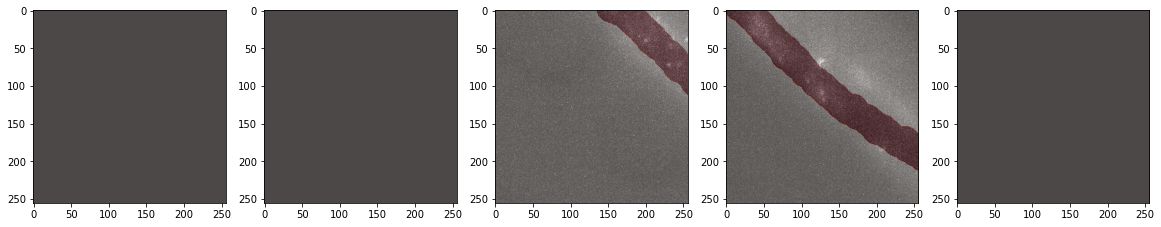

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    ri = np.random.randint(0,4500)
    axs[i].imshow(g_patches_reshaped[ri,...], cmap='gray')
    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)

plt.show()

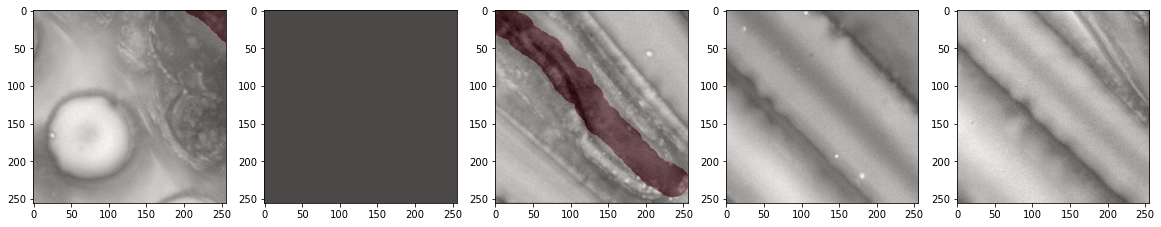

In [44]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    ri = np.random.randint(0,4500)
    axs[i].imshow(bf_patches_reshaped[ri,...], cmap='gray')
    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)

plt.show()

In [45]:
def check_mask(mask,frac,prob):
    if np.sum(mask)>mask.shape[0]*mask.shape[1]*frac:
        return 1
    elif np.random.uniform(0,1)<prob:
        return 1
    else:
        return 0
    
def check_mask_exclude_neg(mask,frac,prob):
    if mask[0,0] == -1:
        return 0
    elif np.sum(mask)>mask.shape[0]*mask.shape[1]*frac:
        return 1
    elif np.random.uniform(0,1)<prob:
        return 1
    else:
        return 0

frac = 0 # fraction of mask pixels needed to deninitely include
prob = 0.1 # fraction of patches with no/low mask pixels to include anyway
accepted_masks = [check_mask_exclude_neg(m,frac,prob) for m in mask_patches_reshaped]
print('fraction accepted: ', sum(accepted_masks)/mask_patches_reshaped.shape[0])

mask_patches_sub = np.array([m for i,m in enumerate(mask_patches_reshaped) if accepted_masks[i]==1])
img_patches_sub_bf = np.array([m for i,m in enumerate(bf_patches_reshaped) if accepted_masks[i]==1])
img_patches_sub_g = np.array([m for i,m in enumerate(g_patches_reshaped) if accepted_masks[i]==1])

print(mask_patches_sub.shape,mask_patches_sub.dtype)
print(img_patches_sub_bf.shape,bf_patches_reshaped.dtype)
print(img_patches_sub_g.shape,g_patches_reshaped.dtype)

fraction accepted:  0.2477777777777778
(1115, 256, 256) float32
(1115, 256, 256) float32
(1115, 256, 256) float32


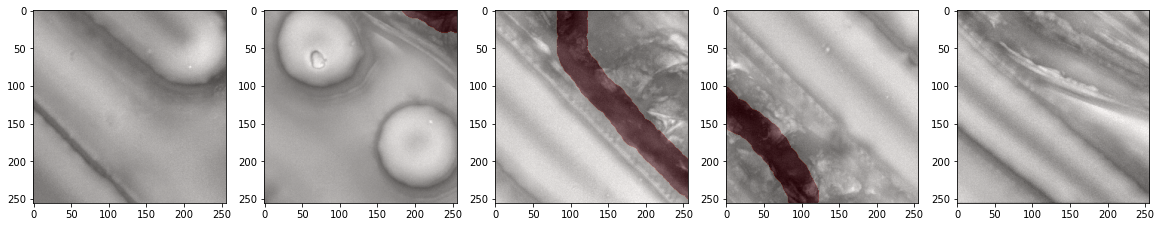

In [46]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    ri = np.random.randint(0,1115)
    axs[i].imshow(img_patches_sub_bf[ri,...], cmap='gray')
    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)

plt.show()

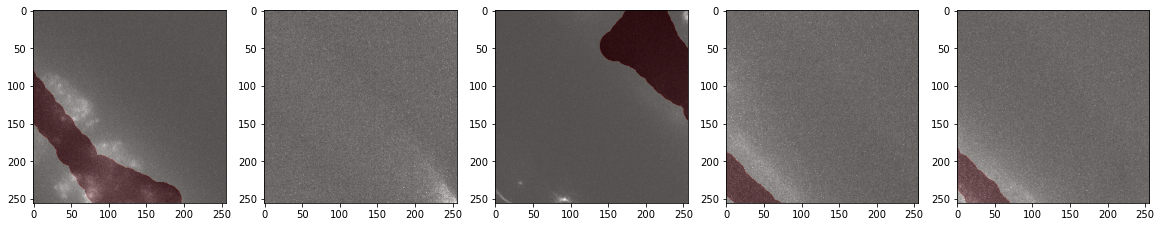

In [48]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    ri = np.random.randint(0,1115)
    axs[i].imshow(img_patches_sub_g[ri,...], cmap='gray')
    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)

plt.show()

In [49]:
folder_path = 'patches'

In [50]:
output_file = os.path.join(folder_path, '53_gut_exp3_patch_bf.tiff')
tifffile.imsave(output_file, img_patches_sub_bf)

output_file = os.path.join(folder_path, '53_gut_exp3_patch_gc.tiff')
tifffile.imsave(output_file, img_patches_sub_g)

output_file = os.path.join(folder_path, '53_gut_exp3_patch_mask.tiff')
tifffile.imsave(output_file, mask_patches_sub)